In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Định nghĩa đường dẫn cơ sở
base_path = '/content/drive/MyDrive/IS403.P23-Gold-main/Dataset/Splits'

# Đọc dữ liệu từ các file CSV đã chia sẵn
train_df = pd.read_csv(os.path.join(base_path, 'train_80_10_10.csv'))
val_df = pd.read_csv(os.path.join(base_path, 'val_80_10_10.csv'))
test_df = pd.read_csv(os.path.join(base_path, 'test_80_10_10.csv'))

Mounted at /content/drive


# 1. Xử lý dữ liệu

In [3]:
# Gộp để chuẩn hóa & sliding window
full_df = pd.concat([train_df, val_df, test_df], ignore_index=True)

# Xử lý cột Date và convert sang datetime
full_df['Date'] = pd.to_datetime(full_df['Date'])

# Convert các cột số: xóa dấu phẩy rồi chuyển sang float
for col in ['Price', 'Open', 'High', 'Low']:
    full_df[col] = full_df[col].str.replace(',', '').astype(float)

# Xử lý cột phần trăm: xóa ký tự '%' rồi chuyển sang float
full_df['Change %'] = full_df['Change %'].str.replace('%', '').astype(float)

# Xử lý cột Vol. với chữ K, M
def parse_volume(val):
    if isinstance(val, str):
        if val.endswith('K'):
            return float(val[:-1]) * 1e3
        elif val.endswith('M'):
            return float(val[:-1]) * 1e6
        else:
            return float(val)
    return np.nan

full_df['Vol.'] = full_df['Vol.'].apply(parse_volume)

full_df = full_df.dropna().sort_values('Date').reset_index(drop=True)

#2. Tạo dữ liệu dạng chuỗi (sliding window)

In [4]:
# Chọn các đặc trưng
features = ['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %', 'CPIAUCSL']

# Chuẩn hóa toàn bộ dữ liệu với StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(full_df[features])

In [5]:
# Tạo dữ liệu với sliding window: timestep = 90
X, y = [], []
timestep = 90
for i in range(timestep, len(scaled_data)):
    X.append(scaled_data[i - timestep:i])
    y.append(scaled_data[i, 0])  # target là giá (Price)

X = np.array(X) # Kích thước: (số mẫu, 90, số features)
y = np.array(y)

In [6]:
# Phân chia lại dữ liệu dựa trên số dòng ban đầu của từng file
n_train = len(train_df) - timestep
n_val   = len(val_df)
n_test  = len(test_df)

X_train = X[:n_train]
y_train = y[:n_train]
X_val   = X[n_train:n_train + n_val]
y_val   = y[n_train:n_train + n_val]
X_test  = X[n_train + n_val:n_train + n_val + n_test]
y_test  = y[n_train + n_val:n_train + n_val + n_test]

# Chuyển dữ liệu cho mô hình ResNet1D dạng tensor, chuyển từ (samples, timestep, features) -> (samples, features, timestep)
X_train_torch = torch.tensor(X_train.transpose(0, 2, 1), dtype=torch.float32)
X_val_torch   = torch.tensor(X_val.transpose(0, 2, 1), dtype=torch.float32)
X_test_torch  = torch.tensor(X_test.transpose(0, 2, 1), dtype=torch.float32)

# Target: giữ dạng (samples, 1)
y_train_torch = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_torch   = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_torch  = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

## 3. Tạo Dataset và DataLoader

In [7]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = TimeSeriesDataset(X_train_torch, y_train_torch)
test_ds  = TimeSeriesDataset(X_test_torch, y_test_torch)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

## 4. Định nghĩa mô hình ResNet1D

In [8]:
class ResNet1D(nn.Module):
    def __init__(self, in_channels, hidden_dim, kernel_size=3, dropout=0.3):
        super(ResNet1D, self).__init__()
        # Lớp Conv đầu tiên với padding cho kernel_size
        self.conv1 = nn.Conv1d(in_channels, hidden_dim, kernel_size=kernel_size, padding=kernel_size//2)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.relu = nn.ReLU()

        # Lớp Conv thứ hai
        self.conv2 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=kernel_size, padding=kernel_size//2)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(dropout)

        # Residual connection: nếu số kênh đầu vào khác hidden_dim dùng conv 1x1
        self.shortcut = nn.Conv1d(in_channels, hidden_dim, kernel_size=1) if in_channels != hidden_dim else None

        # Adaptive Pooling và Fully Connected layer cho đầu ra
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # x: [batch_size, in_channels, timestep]
        residual = x if self.shortcut is None else self.shortcut(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = out + residual
        out = self.relu(out)
        out = self.dropout(out)
        out = self.pool(out).squeeze(-1)  # [batch_size, hidden_dim]
        out = self.fc(out)                # [batch_size, 1]
        return out

In [9]:
# Khởi tạo mô hình
in_channels = X_train_torch.shape[1]  #số kênh đầu vào = số đặc trưng = 7
hidden_dim = 128
model = ResNet1D(in_channels, hidden_dim)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## 5. Huấn luyện mô hình ResNet1D

In [10]:
epochs = 30
train_epoch_losses = []

for epoch in range(epochs):
    model.train()
    epoch_losses = []
    for Xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(Xb)
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
    mean_loss = np.mean(epoch_losses)
    train_epoch_losses.append(mean_loss)
    print(f"Epoch {epoch+1}: Train Loss = {mean_loss:.4f}")

Epoch 1: Train Loss = 0.0681
Epoch 2: Train Loss = 0.0209
Epoch 3: Train Loss = 0.0171
Epoch 4: Train Loss = 0.0139
Epoch 5: Train Loss = 0.0117
Epoch 6: Train Loss = 0.0110
Epoch 7: Train Loss = 0.0113
Epoch 8: Train Loss = 0.0105
Epoch 9: Train Loss = 0.0101
Epoch 10: Train Loss = 0.0109
Epoch 11: Train Loss = 0.0094
Epoch 12: Train Loss = 0.0098
Epoch 13: Train Loss = 0.0092
Epoch 14: Train Loss = 0.0094
Epoch 15: Train Loss = 0.0095
Epoch 16: Train Loss = 0.0095
Epoch 17: Train Loss = 0.0096
Epoch 18: Train Loss = 0.0087
Epoch 19: Train Loss = 0.0091
Epoch 20: Train Loss = 0.0081
Epoch 21: Train Loss = 0.0086
Epoch 22: Train Loss = 0.0082
Epoch 23: Train Loss = 0.0081
Epoch 24: Train Loss = 0.0080
Epoch 25: Train Loss = 0.0078
Epoch 26: Train Loss = 0.0081
Epoch 27: Train Loss = 0.0080
Epoch 28: Train Loss = 0.0081
Epoch 29: Train Loss = 0.0080
Epoch 30: Train Loss = 0.0084


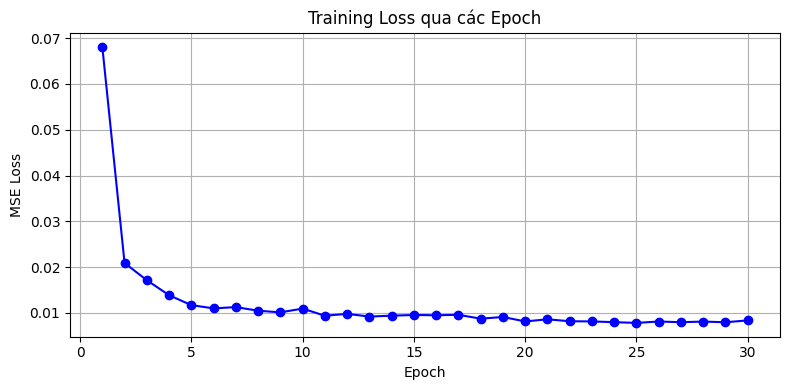

In [11]:
# Vẽ biểu đồ loss theo các epoch
plt.figure(figsize=(8, 4))
plt.plot(range(1, epochs+1), train_epoch_losses, marker='o', linestyle='-', color='b')
plt.title("Training Loss qua các Epoch")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

## 6. Dự đoán và đánh giá trên tập test

In [12]:
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for Xb, yb in test_loader:
        preds = model(Xb)
        all_preds.append(preds.squeeze().numpy())
        all_targets.append(yb.squeeze().numpy())

y_pred = np.concatenate(all_preds)
y_actual = np.concatenate(all_targets)

In [13]:
y_actual_padded = np.hstack((y_actual.reshape(-1, 1), np.zeros((y_actual.shape[0], len(features)-1))))
y_pred_padded   = np.hstack((y_pred.reshape(-1, 1),   np.zeros((y_pred.shape[0], len(features)-1))))
y_actual_orig   = scaler.inverse_transform(y_actual_padded)[:, 0]
y_pred_orig     = scaler.inverse_transform(y_pred_padded)[:, 0]

mae  = mean_absolute_error(y_actual_orig, y_pred_orig)
mape = np.mean(np.abs((y_actual_orig - y_pred_orig) / y_actual_orig)) * 100
rmse = np.sqrt(mean_squared_error(y_actual_orig, y_pred_orig))
r2   = r2_score(y_actual_orig, y_pred_orig)

In [14]:
# Chỉnh lại p là số đặc trưng gốc (7) thay vì timestep * features
n = len(y_actual_orig)
p = len(features)  # 7
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

In [15]:
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")
print(f"Adjusted R²: {adjusted_r2:.4f}")

MAE: 218.0410
MAPE: 8.30%
RMSE: 281.4263
R²: 0.2660
Adjusted R²: 0.2524


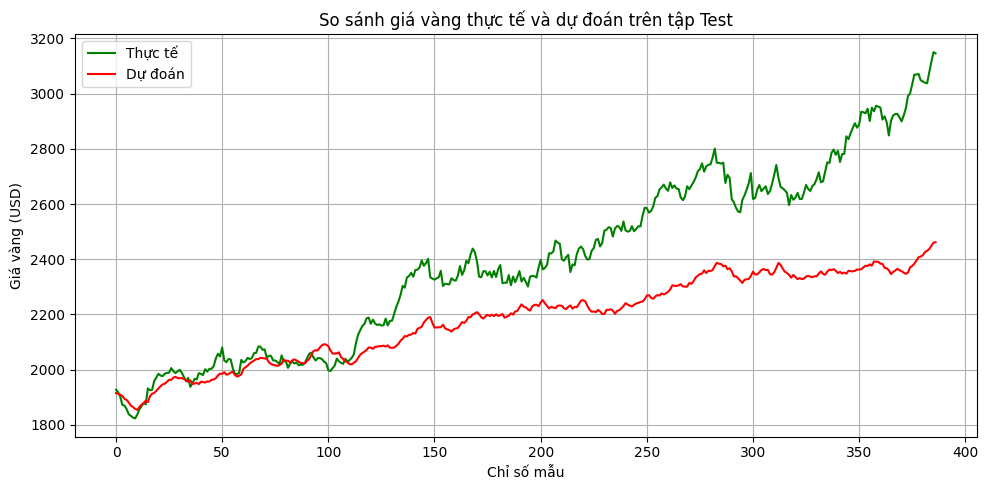

In [16]:
# Vẽ biểu đồ so sánh giá dự đoán và giá thực tế
plt.figure(figsize=(10, 5))
plt.plot(y_actual_orig, label='Thực tế', color='g')
plt.plot(y_pred_orig, label='Dự đoán', color='r')
plt.title("So sánh giá vàng thực tế và dự đoán trên tập Test")
plt.xlabel("Chỉ số mẫu")
plt.ylabel("Giá vàng (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 7. Dự báo 90 ngày tiếp theo với mô hình ResNet1D

In [17]:
def forecast_future_with_details(model, last_sequence, n_future, scaler, timestep, features):
    """
    last_sequence: mảng ndarray với shape (timestep, số feature) – dữ liệu đã scale (chuỗi cuối cùng của test).
    n_future: số ngày dự báo (ví dụ: 90)
    """
    future_predictions = []
    current_sequence = last_sequence.copy()  # shape: (timestep, số features)

    print("Dự báo 90 ngày tiếp theo:\n")
    for day in range(n_future):
        # Chuyển current_sequence về tensor dạng (1, channels, timestep)
        current_sequence_reshaped = torch.tensor(current_sequence.T[np.newaxis, :, :], dtype=torch.float32)
        next_pred = model(current_sequence_reshaped).detach().numpy()  # (1, 1)

        # Inverse transform: tạo vector với giá dự đoán ở cột Price, các cột khác = 0
        predicted_price = scaler.inverse_transform(
            np.concatenate([next_pred, np.zeros((1, len(features)-1))], axis=1)
        )[0, 0]

        # Inverse transform giá của chuỗi input (chỉ lấy cột Price)
        input_prices = scaler.inverse_transform(
            np.concatenate([current_sequence[:, 0].reshape(-1, 1),
                            np.zeros((timestep, len(features)-1))], axis=1)
        )[:, 0]

        print(f"Ngày thứ {day+1}:")
        print(f"Input 90 ngày trước đó (giá, USD): {np.round(input_prices,2)}")
        print(f"Giá dự đoán: {predicted_price:.2f} USD\n")

        future_predictions.append([predicted_price])
        # Cập nhật chuỗi: dịch chuyển sang trái và cập nhật giá mới (giá được scale)
        current_sequence = np.roll(current_sequence, -1, axis=0)
        current_sequence[-1, 0] = next_pred[0, 0]

    return np.array(future_predictions)

In [18]:
# dữ liệu dự báo
last_sequence = X_test[-1].copy()

In [19]:
# Dự báo 90 ngày tiếp theo
future_preds = forecast_future_with_details(model, last_sequence, n_future=90, scaler=scaler,
                                            timestep=timestep, features=features)

Dự báo 90 ngày tiếp theo:

Ngày thứ 1:
Input 90 ngày trước đó (giá, USD): [2631.  2651.7 2674.9 2712.2 2618.5 2621.3 2652.3 2669.  2646.5 2655.9
 2664.3 2636.1 2647.1 2673.3 2705.6 2741.5 2695.1 2662.4 2657.  2649.6
 2640.8 2596.  2632.5 2615.5 2622.8 2640.3 2618.4 2618.1 2641.  2669.
 2654.7 2647.4 2665.4 2672.4 2690.8 2715.  2678.6 2682.3 2717.8 2750.9
 2748.7 2785.6 2797.4 2778.3 2792.7 2752.4 2781.  2781.5 2845.2 2835.
 2857.1 2875.8 2893.  2876.7 2887.6 2934.4 2932.6 2928.7 2945.4 2900.7
 2949.  2936.1 2956.1 2953.2 2949.7 2906.  2917.8 2895.9 2848.5 2901.1
 2920.6 2926.  2926.6 2914.1 2899.4 2920.9 2946.8 2991.3 3001.1 3034.1
 3068.9 3069.1 3071.3 3048.4 3044.  3039.6 3037.3 3075.8 3114.3 3150.3]
Giá dự đoán: 2461.83 USD

Ngày thứ 2:
Input 90 ngày trước đó (giá, USD): [2651.7  2674.9  2712.2  2618.5  2621.3  2652.3  2669.   2646.5  2655.9
 2664.3  2636.1  2647.1  2673.3  2705.6  2741.5  2695.1  2662.4  2657.
 2649.6  2640.8  2596.   2632.5  2615.5  2622.8  2640.3  2618.4  2618.1


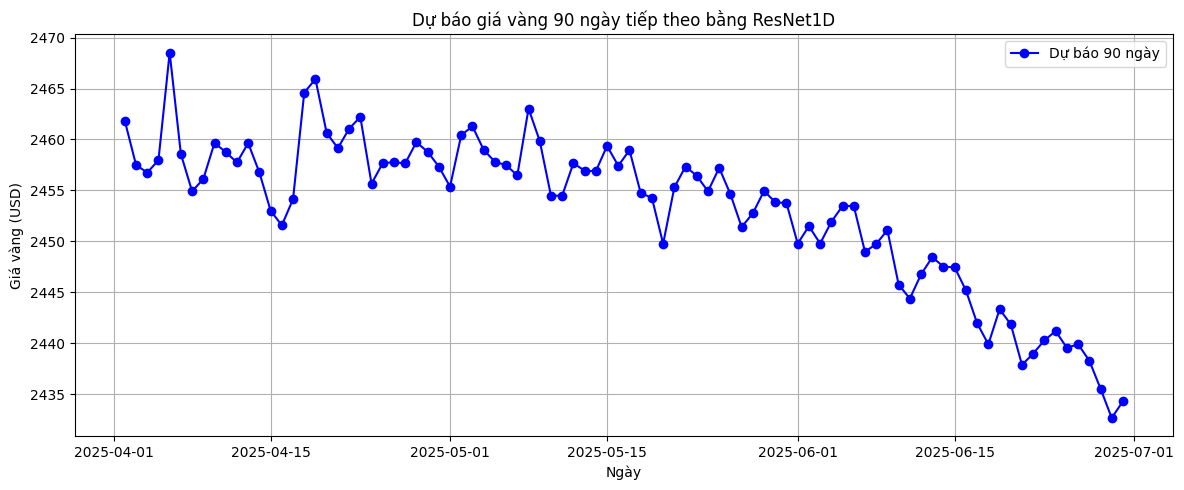

In [20]:
# Vẽ biểu đồ dự báo 90 ngày
future_dates = pd.date_range(start=full_df['Date'].iloc[-1] + datetime.timedelta(days=1), periods=90)
plt.figure(figsize=(12, 5))
plt.plot(future_dates, future_preds, marker='o', linestyle='-', color='b', label='Dự báo 90 ngày')
plt.title("Dự báo giá vàng 90 ngày tiếp theo bằng ResNet1D")
plt.xlabel("Ngày")
plt.ylabel("Giá vàng (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

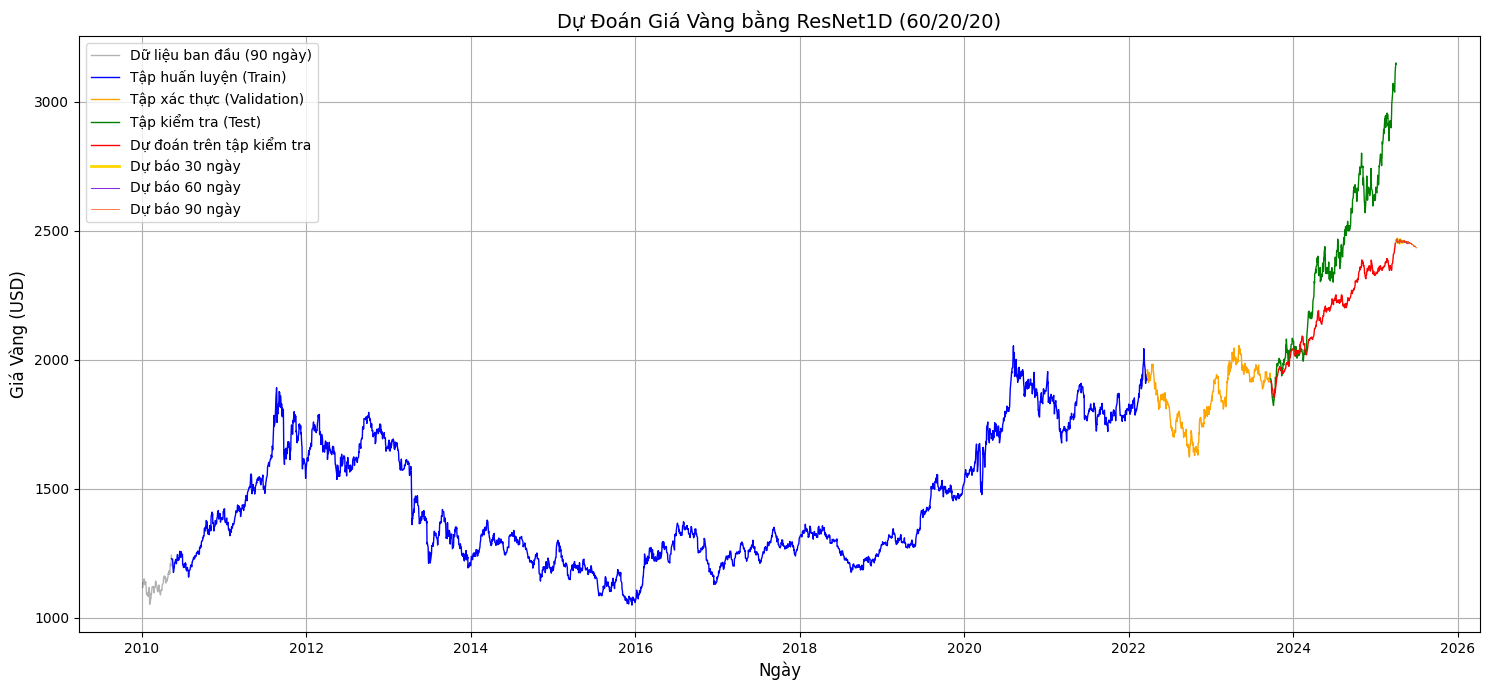

In [21]:
# Vẽ biểu đồ tổng hợp
full_dates = full_df['Date'].values

# Giá gốc của từng tập (đã đảo ngược chuẩn hóa)
train_prices = scaler.inverse_transform(
    np.hstack((y_train.reshape(-1, 1), np.zeros((y_train.shape[0], len(features)-1))))
)[:, 0]
val_prices = scaler.inverse_transform(
    np.hstack((y_val.reshape(-1, 1), np.zeros((y_val.shape[0], len(features)-1))))
)[:, 0]
test_prices = y_actual_orig  # Đã đảo ngược ở bước trước
y_pred_real = y_pred_orig    # Đã đảo ngược ở bước trước

# Ngày tương ứng với từng tập (điều chỉnh vì sliding window làm giảm số mẫu)
train_dates = full_dates[timestep:timestep + len(y_train)]
val_dates = full_dates[timestep + len(y_train):timestep + len(y_train) + len(y_val)]
test_dates = full_dates[timestep + len(y_train) + len(y_val):timestep + len(y_train) + len(y_val) + len(y_test)]

# Trích xuất dự báo 30, 60, 90 ngày từ future_preds
future_30 = future_preds[:30].flatten()
future_60 = future_preds[:60].flatten()
future_90 = future_preds.flatten()

# Giá của 90 ngày đầu tiên (dữ liệu ban đầu)
inv_prices = full_df['Price'].values[:timestep]

# Vẽ biểu đồ
plt.figure(figsize=(15, 7))
plt.plot(full_dates[:timestep], inv_prices, 'k-', label='Dữ liệu ban đầu (90 ngày)', alpha=0.3, linewidth=1.0)
plt.plot(train_dates, train_prices, 'b-', label='Tập huấn luyện (Train)', linewidth=1.0)
plt.plot(val_dates, val_prices, 'orange', label='Tập xác thực (Validation)', linewidth=1.0)
plt.plot(test_dates, test_prices, 'g-', label='Tập kiểm tra (Test)', linewidth=1.0)
plt.plot(test_dates, y_pred_real, 'r-', label='Dự đoán trên tập kiểm tra', linewidth=1.0)
plt.plot(future_dates[:30], future_30, color='#FFD700', label='Dự báo 30 ngày', linewidth=2.0)
plt.plot(future_dates[:60], future_60, color='#8A2BE2', label='Dự báo 60 ngày', linewidth=0.75)
plt.plot(future_dates, future_90, color='#FF4500', label='Dự báo 90 ngày', linewidth=0.5)
plt.title('Dự Đoán Giá Vàng bằng ResNet1D (60/20/20)', fontsize=14)
plt.xlabel('Ngày', fontsize=12)
plt.ylabel('Giá Vàng (USD)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()